In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
import datetime
import copy
import time
import wandb
import pickle as pkl

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles
from viz.fit import plot_histogram, plot_all_histograms, plot_mean_variance, plot_scatter, plot_kl_divergence, plot_heatmap_distribution_sigmas, plot_all_params, plot_all_losses, plot_all_buckets
import yaml

In [3]:
predictions_dict = {}

In [4]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

In [5]:
config_filenames = ['uncer.yaml','default.yaml']
model_names = ['MCMC','BO']

In [6]:
configs = [read_config(cnf) for cnf in config_filenames]

In [7]:
dates = []
for i in range(1):
    dateT = datetime.datetime.now() - datetime.timedelta(days = 80)
    dates.append(dateT)
dates

[datetime.datetime(2020, 8, 24, 11, 44, 38, 829150)]

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
  0%|          | 0/10000 [00:00<?, ?it/s]

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_12112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 109                 | 110                 | 111                 | 112                 | 113                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-08-13 00:00:00 | 2020-08-14 00:00:00 | 2020-08-15 00:00:00 | 2020-08-16 00:00:00 | 2020-08-17 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 126917.14           | 127656.0            | 127716.0            | 128726.0            | 129479.0   

 17%|█▋        | 1669/10000 [00:14<01:09, 119.66it/s]/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:336: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:358: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
  0%|          | 10/10000 [00:00<01:45, 94.81it/s]

The acceptance ratio is -------->  0.2486
The explored steps are -------->  1244
The optimized steps are -------->  1242


  0%|          | 13/10000 [00:00<01:18, 126.56it/s]

The acceptance ratio is -------->  0.249
The explored steps are -------->  1255
The optimized steps are -------->  1235


  0%|          | 12/10000 [00:00<01:25, 116.66it/s]

The acceptance ratio is -------->  0.2356
The explored steps are -------->  1188
The optimized steps are -------->  1168


  0%|          | 0/1500 [00:00<?, ?it/s]

The acceptance ratio is -------->  0.2418
The explored steps are -------->  1222
The optimized steps are -------->  1196
Gelman-Rubin convergence statistics (variance ratios):
{   'E_hosp_ratio': 1.022751915054243,
    'I_hosp_ratio': 1.0117226708977527,
    'P_fatal': 1.0528746957039563,
    'T_inc': 1.002804212746514,
    'T_inf': 1.0226009485819059,
    'T_recov': 1.0445849653588257,
    'T_recov_fatal': 1.0126870293781909,
    'lockdown_R0': 1.0066985319489041,
    'sigma': 1.6502996817851143}


100%|██████████| 1500/1500 [00:14<00:00, 104.01it/s]


best parameters
 OrderedDict([('lockdown_R0', 0.8249646634735244), ('T_inc', 4.269484847126229), ('T_inf', 4.423158220810704), ('T_recov', 18.188073435734704), ('T_recov_fatal', 19.940026631105646), ('P_fatal', 0.04466564920648723), ('E_hosp_ratio', 0.22347056478143362), ('I_hosp_ratio', 0.22523079979875427), ('sigma', 2.6920200102506384)])


/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
  0%|          | 10/10000 [00:00<01:48, 92.20it/s]

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_12112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 109                 | 110                 | 111                 | 112                 | 113                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-08-13 00:00:00 | 2020-08-14 00:00:00 | 2020-08-15 00:00:00 | 2020-08-16 00:00:00 | 2020-08-17 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 126917.14           | 127656.0            | 127716.0            | 128726.0            | 129479.0   

  0%|          | 10/10000 [00:00<01:41, 98.89it/s]

The acceptance ratio is -------->  0.2351
The explored steps are -------->  1159
The optimized steps are -------->  1192


  0%|          | 11/10000 [00:00<01:30, 109.99it/s]

The acceptance ratio is -------->  0.2392
The explored steps are -------->  1192
The optimized steps are -------->  1200


 70%|███████   | 7026/10000 [00:56<00:23, 127.37it/s]/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:336: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:358: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
  0%|          | 12/10000 [00:00<01:26, 116.12it/s]

The acceptance ratio is -------->  0.2528
The explored steps are -------->  1297
The optimized steps are -------->  1231


  0%|          | 0/1500 [00:00<?, ?it/s]

The acceptance ratio is -------->  0.2393
The explored steps are -------->  1207
The optimized steps are -------->  1186
Gelman-Rubin convergence statistics (variance ratios):
{   'E_hosp_ratio': 1.0158968469130074,
    'I_hosp_ratio': 1.015462509183352,
    'P_fatal': 1.0309451857647227,
    'T_inc': 1.0030840838055743,
    'T_inf': 1.0620943189025283,
    'T_recov': 1.0430058921875196,
    'T_recov_fatal': 1.0276951140264239,
    'lockdown_R0': 1.0281998467377615,
    'sigma': 1.7209386223061771}


100%|██████████| 1500/1500 [00:15<00:00, 97.58it/s] 


best parameters
 OrderedDict([('lockdown_R0', 0.7057396509455992), ('T_inc', 4.990694643115018), ('T_inf', 4.150142136571469), ('T_recov', 17.19586555701988), ('T_recov_fatal', 21.183016550186625), ('P_fatal', 0.04737623380136873), ('E_hosp_ratio', 0.46360316651559336), ('I_hosp_ratio', 0.10086205189323998), ('sigma', 1.171960666531375)])


/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
  0%|          | 11/10000 [00:00<01:31, 109.45it/s]

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_12112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 109                 | 110                 | 111                 | 112                 | 113                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-08-13 00:00:00 | 2020-08-14 00:00:00 | 2020-08-15 00:00:00 | 2020-08-16 00:00:00 | 2020-08-17 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 126917.14           | 127656.0            | 127716.0            | 128726.0            | 129479.0   

  0%|          | 12/10000 [00:00<01:23, 119.16it/s]

The acceptance ratio is -------->  0.2412
The explored steps are -------->  1188
The optimized steps are -------->  1224


  0%|          | 11/10000 [00:00<01:39, 99.98it/s]

The acceptance ratio is -------->  0.2473
The explored steps are -------->  1250
The optimized steps are -------->  1223


  0%|          | 10/10000 [00:00<01:43, 96.37it/s]

The acceptance ratio is -------->  0.2418
The explored steps are -------->  1196
The optimized steps are -------->  1222


  0%|          | 0/1500 [00:00<?, ?it/s]

The acceptance ratio is -------->  0.2443
The explored steps are -------->  1216
The optimized steps are -------->  1227
Gelman-Rubin convergence statistics (variance ratios):
{   'E_hosp_ratio': 1.0127436603896596,
    'I_hosp_ratio': 1.0089063991620109,
    'P_fatal': 1.014750203311784,
    'T_inc': 1.0069475053647134,
    'T_inf': 1.0116195598758486,
    'T_recov': 1.00796756889077,
    'T_recov_fatal': 1.0160506747137616,
    'lockdown_R0': 1.0053039164504156,
    'sigma': 1.2693321028536158}


100%|██████████| 1500/1500 [00:14<00:00, 103.62it/s]


best parameters
 OrderedDict([('lockdown_R0', 0.8672538388392315), ('T_inc', 3.8192467118488604), ('T_inf', 4.599722192974093), ('T_recov', 18.208821109598365), ('T_recov_fatal', 27.870528520053725), ('P_fatal', 0.060638357151486494), ('E_hosp_ratio', 0.05609631683985089), ('I_hosp_ratio', 0.33462385704353614), ('sigma', 1.4769809469786803)])


/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
  0%|          | 10/10000 [00:00<01:45, 94.78it/s]

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_12112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 109                 | 110                 | 111                 | 112                 | 113                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-08-13 00:00:00 | 2020-08-14 00:00:00 | 2020-08-15 00:00:00 | 2020-08-16 00:00:00 | 2020-08-17 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 126917.14           | 127656.0            | 127716.0            | 128726.0            | 129479.0   

  0%|          | 11/10000 [00:00<01:38, 101.79it/s]

The acceptance ratio is -------->  0.2486
The explored steps are -------->  1256
The optimized steps are -------->  1230


  0%|          | 12/10000 [00:00<01:28, 112.67it/s]

The acceptance ratio is -------->  0.241
The explored steps are -------->  1172
The optimized steps are -------->  1238


  8%|▊         | 761/10000 [00:06<01:12, 127.36it/s]/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:336: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:358: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
  0%|          | 10/10000 [00:00<01:46, 93.89it/s]

The acceptance ratio is -------->  0.2446
The explored steps are -------->  1193
The optimized steps are -------->  1253


  0%|          | 0/1500 [00:00<?, ?it/s]

The acceptance ratio is -------->  0.2485
The explored steps are -------->  1221
The optimized steps are -------->  1264
Gelman-Rubin convergence statistics (variance ratios):
{   'E_hosp_ratio': 1.0112370930569594,
    'I_hosp_ratio': 1.0082726211940998,
    'P_fatal': 1.0319966250883739,
    'T_inc': 1.0026850403328216,
    'T_inf': 1.0145302472009001,
    'T_recov': 1.0290176059318936,
    'T_recov_fatal': 1.015391430260942,
    'lockdown_R0': 1.0115615380273872,
    'sigma': 1.4940245516947797}


100%|██████████| 1500/1500 [00:14<00:00, 103.99it/s]


best parameters
 OrderedDict([('lockdown_R0', 0.7678845051793822), ('T_inc', 4.6537417139121), ('T_inf', 4.64452195001171), ('T_recov', 18.19311802555351), ('T_recov_fatal', 29.32246483575768), ('P_fatal', 0.06385443017071055), ('E_hosp_ratio', 0.3188721622129961), ('I_hosp_ratio', 0.17654457382743152), ('sigma', 2.259494925052369)])


/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
  0%|          | 12/10000 [00:00<01:26, 114.88it/s]

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_12112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 109                 | 110                 | 111                 | 112                 | 113                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-08-13 00:00:00 | 2020-08-14 00:00:00 | 2020-08-15 00:00:00 | 2020-08-16 00:00:00 | 2020-08-17 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 126917.14           | 127656.0            | 127716.0            | 128726.0            | 129479.0   

  0%|          | 10/10000 [00:00<01:41, 97.98it/s]

The acceptance ratio is -------->  0.2419
The explored steps are -------->  1203
The optimized steps are -------->  1216


 47%|████▋     | 4723/10000 [00:39<00:41, 125.81it/s]/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:336: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:358: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
  0%|          | 13/10000 [00:00<01:21, 123.26it/s]

The acceptance ratio is -------->  0.2497
The explored steps are -------->  1219
The optimized steps are -------->  1278


  0%|          | 12/10000 [00:00<01:35, 104.39it/s]

The acceptance ratio is -------->  0.2349
The explored steps are -------->  1184
The optimized steps are -------->  1165


  0%|          | 0/1500 [00:00<?, ?it/s]

The acceptance ratio is -------->  0.2487
The explored steps are -------->  1246
The optimized steps are -------->  1241
Gelman-Rubin convergence statistics (variance ratios):
{   'E_hosp_ratio': 1.0053494655547883,
    'I_hosp_ratio': 1.0058744721783879,
    'P_fatal': 1.0375899363657273,
    'T_inc': 1.0048413970825907,
    'T_inf': 1.0173121013710544,
    'T_recov': 1.0379704828196417,
    'T_recov_fatal': 1.0208082557126503,
    'lockdown_R0': 1.0079962489417549,
    'sigma': 2.2283625299330905}


100%|██████████| 1500/1500 [00:14<00:00, 103.67it/s]


best parameters
 OrderedDict([('lockdown_R0', 0.7764268538224052), ('T_inc', 4.154887064904652), ('T_inf', 4.825783870195904), ('T_recov', 17.17028038802282), ('T_recov_fatal', 36.38805282744123), ('P_fatal', 0.07104685565064), ('E_hosp_ratio', 0.21299133370475293), ('I_hosp_ratio', 0.25695163552827016), ('sigma', 2.280839243837934)])


/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
  0%|          | 10/10000 [00:00<01:41, 98.80it/s]

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_12112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 109                 | 110                 | 111                 | 112                 | 113                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-08-13 00:00:00 | 2020-08-14 00:00:00 | 2020-08-15 00:00:00 | 2020-08-16 00:00:00 | 2020-08-17 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 126917.14           | 127656.0            | 127716.0            | 128726.0            | 129479.0   

  0%|          | 10/10000 [00:00<01:52, 89.13it/s]

The acceptance ratio is -------->  0.2371
The explored steps are -------->  1148
The optimized steps are -------->  1223


  0%|          | 10/10000 [00:00<01:45, 94.62it/s]

The acceptance ratio is -------->  0.2497
The explored steps are -------->  1270
The optimized steps are -------->  1227


  0%|          | 12/10000 [00:00<01:26, 115.59it/s]

The acceptance ratio is -------->  0.2422
The explored steps are -------->  1213
The optimized steps are -------->  1209


  0%|          | 0/1500 [00:00<?, ?it/s]

The acceptance ratio is -------->  0.2347
The explored steps are -------->  1141
The optimized steps are -------->  1206
Gelman-Rubin convergence statistics (variance ratios):
{   'E_hosp_ratio': 1.0074782668830338,
    'I_hosp_ratio': 1.0083690938763943,
    'P_fatal': 1.0569822342150148,
    'T_inc': 1.0023062438259365,
    'T_inf': 1.0247870666849042,
    'T_recov': 1.0101237733250032,
    'T_recov_fatal': 1.0163553008929205,
    'lockdown_R0': 1.0044005007210057,
    'sigma': 1.4234360526397303}


100%|██████████| 1500/1500 [00:14<00:00, 101.45it/s]


best parameters
 OrderedDict([('lockdown_R0', 0.7486260220167462), ('T_inc', 3.933414368680951), ('T_inf', 4.571959480319632), ('T_recov', 17.932326700499594), ('T_recov_fatal', 29.495283928090537), ('P_fatal', 0.062497635657653886), ('E_hosp_ratio', 0.2884402239845715), ('I_hosp_ratio', 0.2023941146955157), ('sigma', 2.020460129741096)])


/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
  0%|          | 9/10000 [00:00<01:53, 88.02it/s]

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_12112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 109                 | 110                 | 111                 | 112                 | 113                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-08-13 00:00:00 | 2020-08-14 00:00:00 | 2020-08-15 00:00:00 | 2020-08-16 00:00:00 | 2020-08-17 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 126917.14           | 127656.0            | 127716.0            | 128726.0            | 129479.0   

  0%|          | 11/10000 [00:00<01:36, 103.24it/s]

The acceptance ratio is -------->  0.2421
The explored steps are -------->  1199
The optimized steps are -------->  1222


  0%|          | 12/10000 [00:00<01:32, 107.71it/s]

The acceptance ratio is -------->  0.2391
The explored steps are -------->  1199
The optimized steps are -------->  1192


  0%|          | 12/10000 [00:00<01:27, 113.74it/s]

The acceptance ratio is -------->  0.2335
The explored steps are -------->  1158
The optimized steps are -------->  1177


 51%|█████     | 5069/10000 [00:38<00:37, 131.24it/s]/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:336: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:358: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
  0%|          | 0/1500 [00:00<?, ?it/s]

The acceptance ratio is -------->  0.2469
The explored steps are -------->  1246
The optimized steps are -------->  1223
Gelman-Rubin convergence statistics (variance ratios):
{   'E_hosp_ratio': 1.0099672864552374,
    'I_hosp_ratio': 1.0043809955030152,
    'P_fatal': 1.0187009842315315,
    'T_inc': 1.0104439153125753,
    'T_inf': 1.0162563902217079,
    'T_recov': 1.0227589973603897,
    'T_recov_fatal': 1.0189044932020674,
    'lockdown_R0': 1.005964391758035,
    'sigma': 1.4873249463945681}


100%|██████████| 1500/1500 [00:13<00:00, 109.88it/s]


best parameters
 OrderedDict([('lockdown_R0', 0.7056559276397179), ('T_inc', 4.894609429966341), ('T_inf', 4.83400301748129), ('T_recov', 17.72670364097943), ('T_recov_fatal', 34.29318938126332), ('P_fatal', 0.07330677100831473), ('E_hosp_ratio', 0.33187364749330545), ('I_hosp_ratio', 0.2194143205574109), ('sigma', 1.05367448498449)])


/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
  0%|          | 10/10000 [00:00<01:42, 97.62it/s]

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_12112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 109                 | 110                 | 111                 | 112                 | 113                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-08-13 00:00:00 | 2020-08-14 00:00:00 | 2020-08-15 00:00:00 | 2020-08-16 00:00:00 | 2020-08-17 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 126917.14           | 127656.0            | 127716.0            | 128726.0            | 129479.0   

  0%|          | 12/10000 [00:00<01:30, 110.05it/s]

The acceptance ratio is -------->  0.2357
The explored steps are -------->  1151
The optimized steps are -------->  1206


  0%|          | 13/10000 [00:00<01:17, 128.54it/s]

The acceptance ratio is -------->  0.2493
The explored steps are -------->  1219
The optimized steps are -------->  1274


  0%|          | 16/10000 [00:00<01:02, 159.10it/s]

The acceptance ratio is -------->  0.2446
The explored steps are -------->  1226
The optimized steps are -------->  1220


  0%|          | 0/1500 [00:00<?, ?it/s]

The acceptance ratio is -------->  0.2452
The explored steps are -------->  1231
The optimized steps are -------->  1221
Gelman-Rubin convergence statistics (variance ratios):
{   'E_hosp_ratio': 1.009696698649413,
    'I_hosp_ratio': 1.006384265371638,
    'P_fatal': 1.0432636157070014,
    'T_inc': 1.0096053874397473,
    'T_inf': 1.0251651131331236,
    'T_recov': 1.0257764293823686,
    'T_recov_fatal': 1.0087661932647805,
    'lockdown_R0': 1.0054220412338104,
    'sigma': 1.2956045788070398}


100%|██████████| 1500/1500 [00:13<00:00, 110.64it/s]


best parameters
 OrderedDict([('lockdown_R0', 0.7466705108776238), ('T_inc', 3.035317602997377), ('T_inf', 4.673782758906412), ('T_recov', 18.52503493234503), ('T_recov_fatal', 16.365631067576775), ('P_fatal', 0.04499069489427438), ('E_hosp_ratio', 0.1979914390745915), ('I_hosp_ratio', 0.23409203738530512), ('sigma', 2.3051053502724708)])


/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
  0%|          | 0/10000 [00:00<?, ?it/s]

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_12112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 109                 | 110                 | 111                 | 112                 | 113                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-08-13 00:00:00 | 2020-08-14 00:00:00 | 2020-08-15 00:00:00 | 2020-08-16 00:00:00 | 2020-08-17 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 126917.14           | 127656.0            | 127716.0            | 128726.0            | 129479.0   

  0%|          | 8/10000 [00:00<02:04, 80.00it/s]

The acceptance ratio is -------->  0.2448
The explored steps are -------->  1206
The optimized steps are -------->  1242


  0%|          | 12/10000 [00:00<01:25, 117.21it/s]

The acceptance ratio is -------->  0.2426
The explored steps are -------->  1199
The optimized steps are -------->  1227


  0%|          | 11/10000 [00:00<01:31, 108.93it/s]

The acceptance ratio is -------->  0.231
The explored steps are -------->  1150
The optimized steps are -------->  1160


 11%|█▏        | 1149/10000 [00:08<01:03, 138.96it/s]/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:336: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/scipy/integrate/_ivp/common.py:358: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
  0%|          | 0/1500 [00:00<?, ?it/s]

The acceptance ratio is -------->  0.2315
The explored steps are -------->  1163
The optimized steps are -------->  1152
Gelman-Rubin convergence statistics (variance ratios):
{   'E_hosp_ratio': 1.007020452362168,
    'I_hosp_ratio': 1.0047720379419975,
    'P_fatal': 1.023002261080103,
    'T_inc': 1.0009073054721882,
    'T_inf': 1.0244811166746262,
    'T_recov': 1.0148057553656176,
    'T_recov_fatal': 1.0042762168819823,
    'lockdown_R0': 1.0046269479232022,
    'sigma': 1.9002825264087284}


100%|██████████| 1500/1500 [00:13<00:00, 110.21it/s]


best parameters
 OrderedDict([('lockdown_R0', 0.7763225051534661), ('T_inc', 4.049245555968372), ('T_inf', 4.477919650521696), ('T_recov', 17.470973860035297), ('T_recov_fatal', 27.01876339937726), ('P_fatal', 0.05825656056157777), ('E_hosp_ratio', 0.2573976342793321), ('I_hosp_ratio', 0.21319544303226215), ('sigma', 2.830674911176112)])


/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
  0%|          | 11/10000 [00:00<01:31, 109.67it/s]

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_12112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 109                 | 110                 | 111                 | 112                 | 113                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-08-13 00:00:00 | 2020-08-14 00:00:00 | 2020-08-15 00:00:00 | 2020-08-16 00:00:00 | 2020-08-17 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 126917.14           | 127656.0            | 127716.0            | 128726.0            | 129479.0   

  0%|          | 11/10000 [00:00<01:40, 99.49it/s]

The acceptance ratio is -------->  0.2439
The explored steps are -------->  1219
The optimized steps are -------->  1220


  0%|          | 10/10000 [00:00<01:41, 98.12it/s]

The acceptance ratio is -------->  0.2459
The explored steps are -------->  1237
The optimized steps are -------->  1222


  0%|          | 13/10000 [00:00<01:22, 121.23it/s]

The acceptance ratio is -------->  0.2408
The explored steps are -------->  1177
The optimized steps are -------->  1231


  0%|          | 0/1500 [00:00<?, ?it/s]

The acceptance ratio is -------->  0.2455
The explored steps are -------->  1234
The optimized steps are -------->  1221
Gelman-Rubin convergence statistics (variance ratios):
{   'E_hosp_ratio': 1.0070559548979552,
    'I_hosp_ratio': 1.0062339905067277,
    'P_fatal': 1.0380093063532272,
    'T_inc': 1.0026802557265913,
    'T_inf': 1.006087046226921,
    'T_recov': 1.0303986632706306,
    'T_recov_fatal': 1.0418137226891864,
    'lockdown_R0': 1.0168020114212872,
    'sigma': 2.3085096744832208}


100%|██████████| 1500/1500 [00:13<00:00, 112.11it/s]


best parameters
 OrderedDict([('lockdown_R0', 0.7733967729278655), ('T_inc', 3.950455939049492), ('T_inf', 4.508194791613194), ('T_recov', 17.94592763858161), ('T_recov_fatal', 30.279869280442327), ('P_fatal', 0.057817416185898834), ('E_hosp_ratio', 0.1759494264262561), ('I_hosp_ratio', 0.262530971268619), ('sigma', 2.934577067702189)])
Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_12112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 109                 | 110                 | 111                 | 112                 | 113                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-08-13 00:00:00 | 2020-08-14 00:00:00 | 2020-08-15 00:00:00 | 2020-08-16 00:00:00 | 2020-08-17 00:00:00 |
| state       | Maharashtra 

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


100%|██████████| 1500/1500 [00:47<00:00, 31.80trial/s, best loss: 0.5646007979592862]
best parameters
 {'E_hosp_ratio': 0.2839234128239578, 'I_hosp_ratio': 0.14848847964969145, 'P_fatal': 0.04135246409994691, 'T_inc': 4.277348579077378, 'T_inf': 3.657042122871094, 'T_recov': 18.028792328263652, 'T_recov_fatal': 14.10015504693548, 'lockdown_R0': 0.8463043600334517}
Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_12112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 109                 | 110                 | 111                 | 112                 | 113                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-08-13 00:00:00 | 2020-08-14 00:00:00 | 2020-08-15 00:00:00 | 2020-08-16 00:00:00 | 2020-08-17 00:00:00 |


/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


100%|██████████| 1500/1500 [00:47<00:00, 31.61trial/s, best loss: 0.41703212067918893]
best parameters
 {'E_hosp_ratio': 0.3290910542083083, 'I_hosp_ratio': 0.14150780072390887, 'P_fatal': 0.06515949785002435, 'T_inc': 4.891060055970325, 'T_inf': 3.1695363437411133, 'T_recov': 17.369015322911835, 'T_recov_fatal': 31.789029605045197, 'lockdown_R0': 0.7081676307114338}
Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_12112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 109                 | 110                 | 111                 | 112                 | 113                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-08-13 00:00:00 | 2020-08-14 00:00:00 | 2020-08-15 00:00:00 | 2020-08-16 00:00:00 | 2020-08-17 00:00:00

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


100%|██████████| 1500/1500 [00:46<00:00, 31.93trial/s, best loss: 0.648255805703611]
best parameters
 {'E_hosp_ratio': 0.24099215983504485, 'I_hosp_ratio': 0.15646309611365933, 'P_fatal': 0.06335106321296699, 'T_inc': 4.566776986049863, 'T_inf': 3.0420768456485243, 'T_recov': 17.951168520896445, 'T_recov_fatal': 23.517797587328666, 'lockdown_R0': 0.8385883781767807}
Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_12112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 109                 | 110                 | 111                 | 112                 | 113                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-08-13 00:00:00 | 2020-08-14 00:00:00 | 2020-08-15 00:00:00 | 2020-08-16 00:00:00 | 2020-08-17 00:00:00 

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


100%|██████████| 1500/1500 [00:47<00:00, 31.56trial/s, best loss: 0.6401239788198894]
best parameters
 {'E_hosp_ratio': 0.038143631992356763, 'I_hosp_ratio': 0.3148703449757159, 'P_fatal': 0.07063347183510774, 'T_inc': 4.785717931129583, 'T_inf': 3.896821908164496, 'T_recov': 18.03706012516734, 'T_recov_fatal': 33.9220559829017, 'lockdown_R0': 0.9510203279865012}
Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_12112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 109                 | 110                 | 111                 | 112                 | 113                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-08-13 00:00:00 | 2020-08-14 00:00:00 | 2020-08-15 00:00:00 | 2020-08-16 00:00:00 | 2020-08-17 00:00:00 |
|

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


100%|██████████| 1500/1500 [00:47<00:00, 31.89trial/s, best loss: 0.5659320786230762]
best parameters
 {'E_hosp_ratio': 0.16465508797952336, 'I_hosp_ratio': 0.19476596741757934, 'P_fatal': 0.05394003953335204, 'T_inc': 4.434025263794319, 'T_inf': 3.5591266014109135, 'T_recov': 18.436666893897044, 'T_recov_fatal': 23.999417604705027, 'lockdown_R0': 0.9312454251864439}
Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_12112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 109                 | 110                 | 111                 | 112                 | 113                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-08-13 00:00:00 | 2020-08-14 00:00:00 | 2020-08-15 00:00:00 | 2020-08-16 00:00:00 | 2020-08-17 00:00:00

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


100%|██████████| 1500/1500 [00:46<00:00, 32.27trial/s, best loss: 0.5595826962050603]
best parameters
 {'E_hosp_ratio': 0.25078709930552207, 'I_hosp_ratio': 0.15222884788540247, 'P_fatal': 0.05227303602101459, 'T_inc': 4.081195353636343, 'T_inf': 3.452689037328464, 'T_recov': 18.47694157516858, 'T_recov_fatal': 25.735267053007654, 'lockdown_R0': 0.8228666075634234}
Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_12112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 109                 | 110                 | 111                 | 112                 | 113                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-08-13 00:00:00 | 2020-08-14 00:00:00 | 2020-08-15 00:00:00 | 2020-08-16 00:00:00 | 2020-08-17 00:00:00 |

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


100%|██████████| 1500/1500 [00:47<00:00, 31.60trial/s, best loss: 0.44563777812403027]
best parameters
 {'E_hosp_ratio': 0.309623779069423, 'I_hosp_ratio': 0.1585234986377445, 'P_fatal': 0.08123027521142742, 'T_inc': 4.870755565009433, 'T_inf': 3.20737529420679, 'T_recov': 17.408092124221625, 'T_recov_fatal': 39.86427384298662, 'lockdown_R0': 0.7075787868627624}
Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_12112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 109                 | 110                 | 111                 | 112                 | 113                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-08-13 00:00:00 | 2020-08-14 00:00:00 | 2020-08-15 00:00:00 | 2020-08-16 00:00:00 | 2020-08-17 00:00:00 |
| 

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


100%|██████████| 1500/1500 [00:47<00:00, 31.91trial/s, best loss: 0.3235045844971958]
best parameters
 {'E_hosp_ratio': 0.28341923924083, 'I_hosp_ratio': 0.1678570656368233, 'P_fatal': 0.059669900494324794, 'T_inc': 4.372273241204996, 'T_inf': 3.7610848923325864, 'T_recov': 17.87591488294803, 'T_recov_fatal': 27.368234853688115, 'lockdown_R0': 0.7827912521050334}
Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_12112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 109                 | 110                 | 111                 | 112                 | 113                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-08-13 00:00:00 | 2020-08-14 00:00:00 | 2020-08-15 00:00:00 | 2020-08-16 00:00:00 | 2020-08-17 00:00:00 |
|

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


100%|██████████| 1500/1500 [00:47<00:00, 31.75trial/s, best loss: 0.37994887294750695]
best parameters
 {'E_hosp_ratio': 0.35735097597652843, 'I_hosp_ratio': 0.09954527439176386, 'P_fatal': 0.069413226089098, 'T_inc': 4.168567320096133, 'T_inf': 3.5397230762111955, 'T_recov': 17.333283910767406, 'T_recov_fatal': 32.72929791274447, 'lockdown_R0': 0.7605591527726794}
Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_12112020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 109                 | 110                 | 111                 | 112                 | 113                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-08-13 00:00:00 | 2020-08-14 00:00:00 | 2020-08-15 00:00:00 | 2020-08-16 00:00:00 | 2020-08-17 00:00:00 |

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


100%|██████████| 1500/1500 [00:47<00:00, 31.71trial/s, best loss: 0.5012968830438742]
best parameters
 {'E_hosp_ratio': 0.20518363761043956, 'I_hosp_ratio': 0.18609710996882206, 'P_fatal': 0.05722147531178231, 'T_inc': 4.069886699413118, 'T_inf': 3.750128951957501, 'T_recov': 17.542495288436644, 'T_recov_fatal': 25.541565935616624, 'lockdown_R0': 0.9252606241718825}


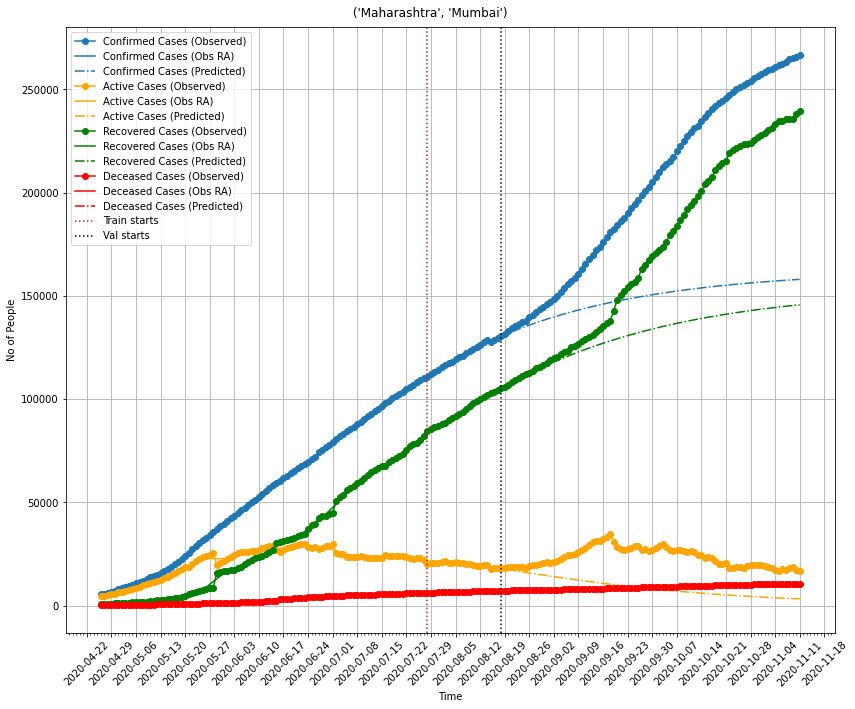

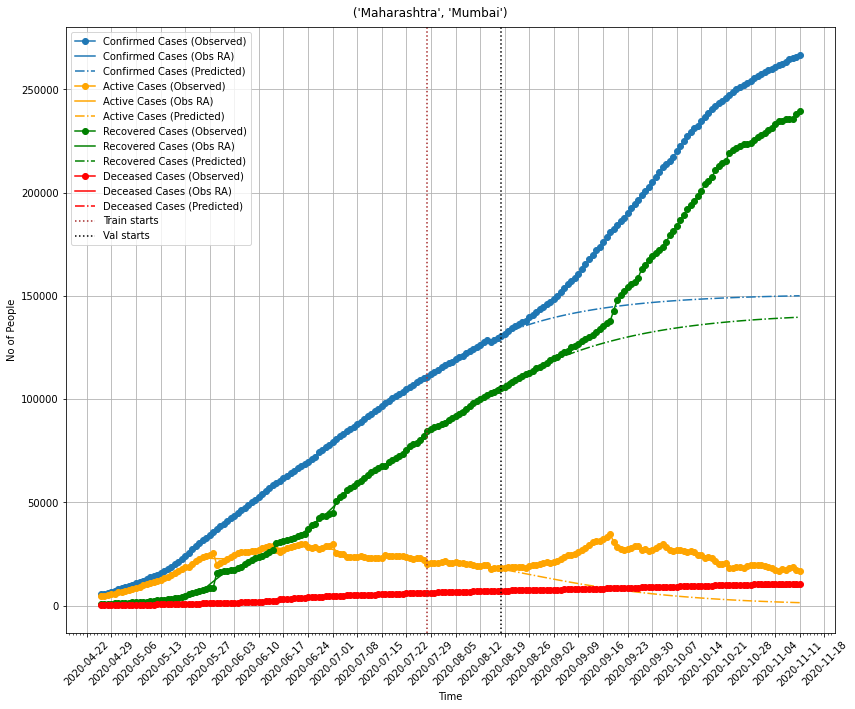

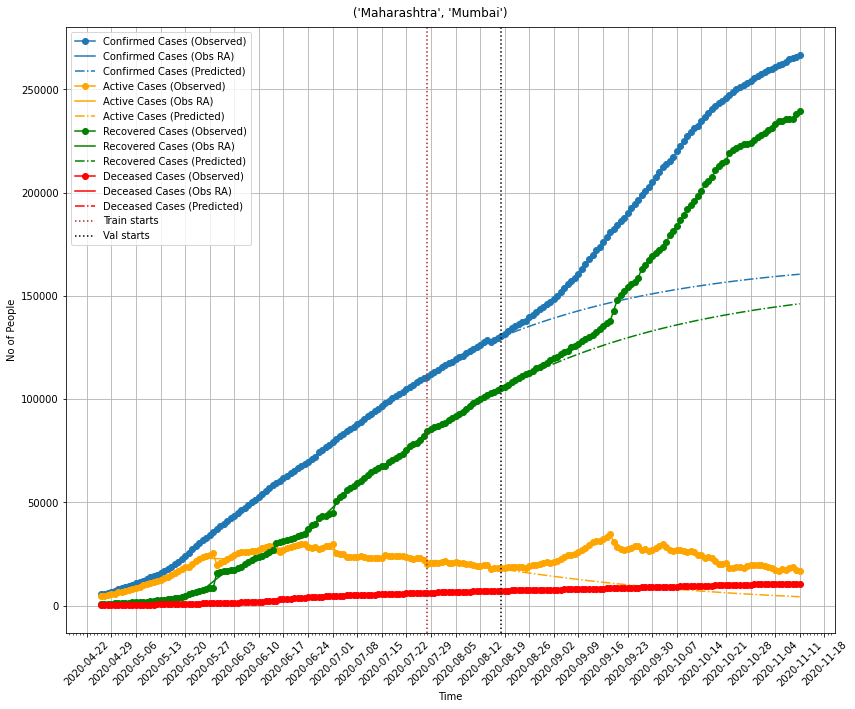

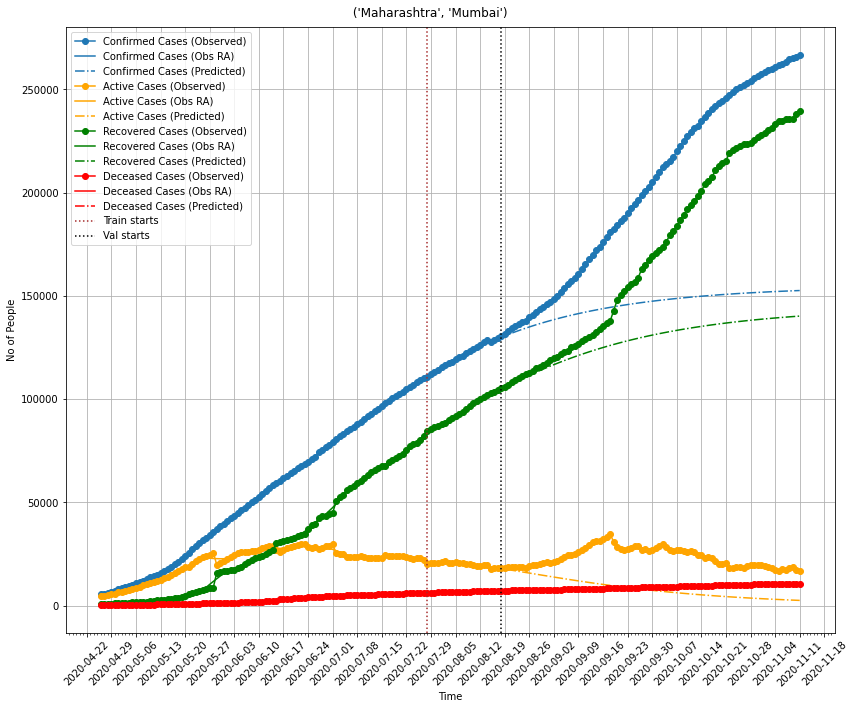

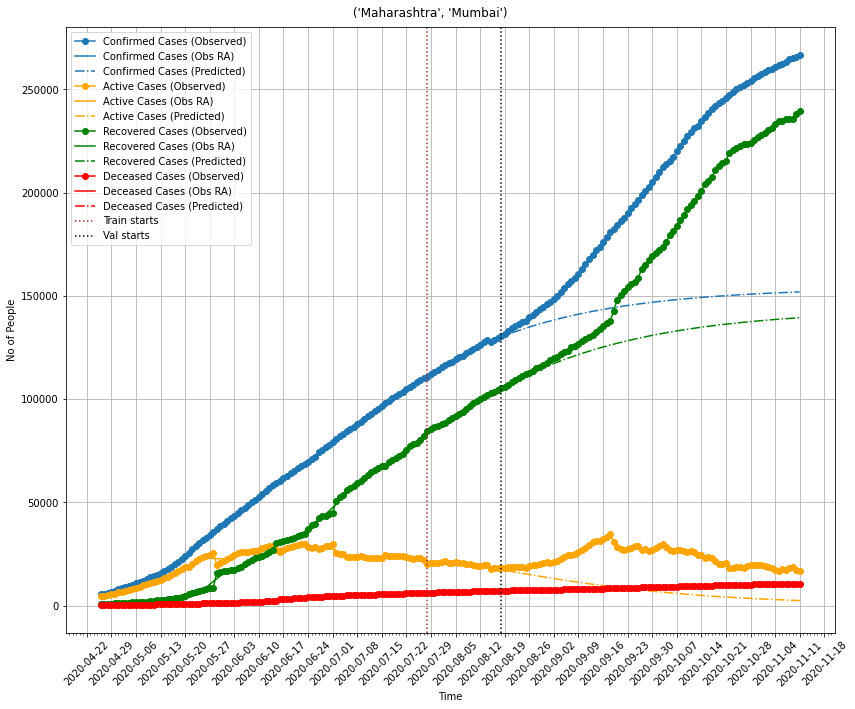

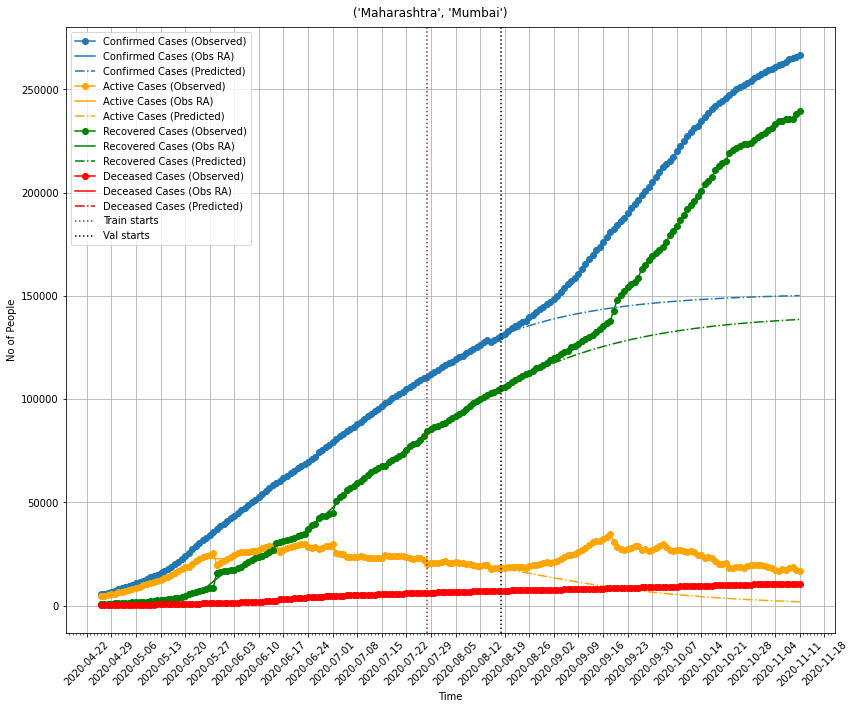

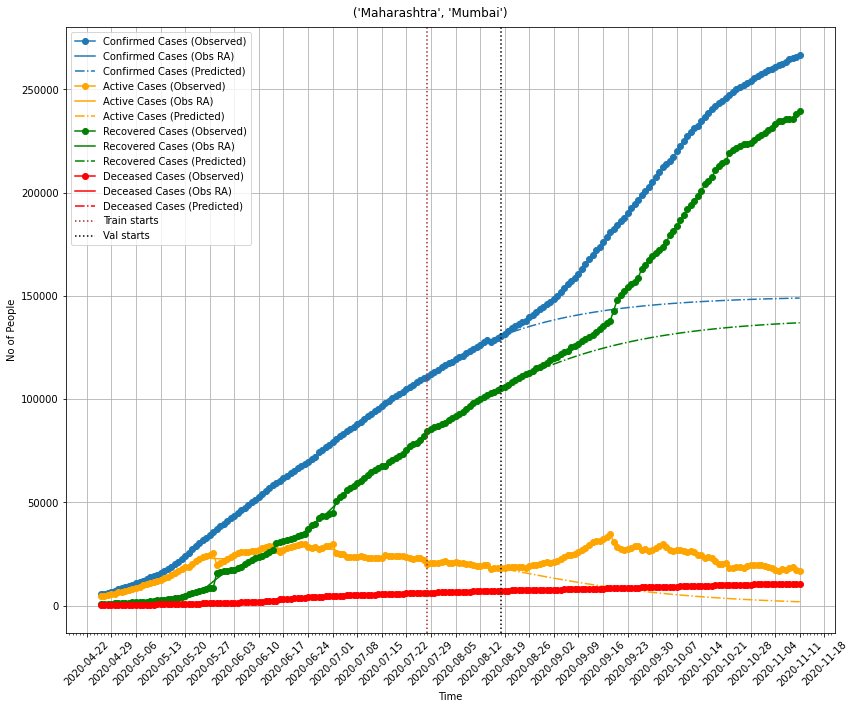

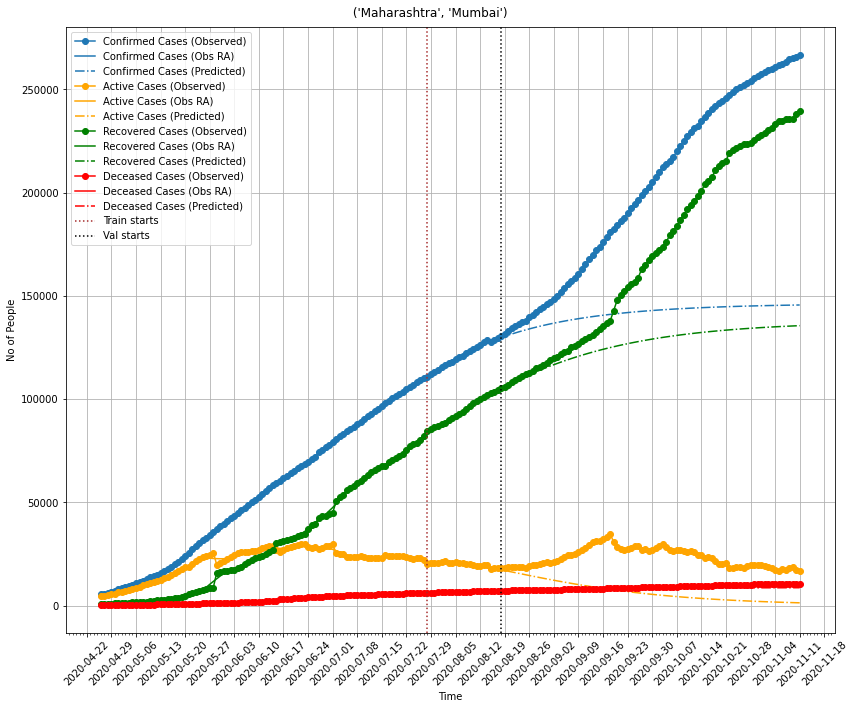

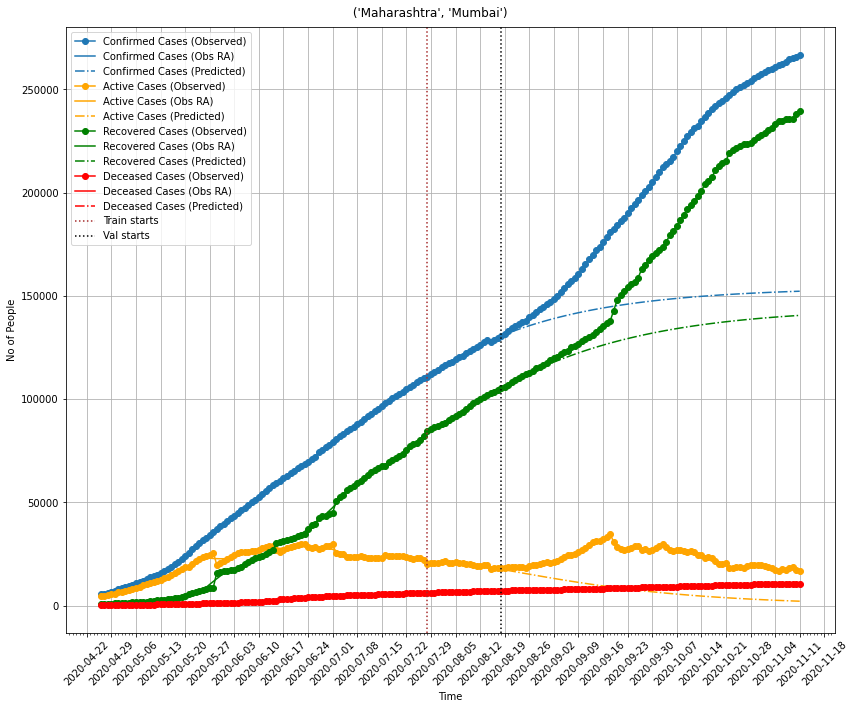

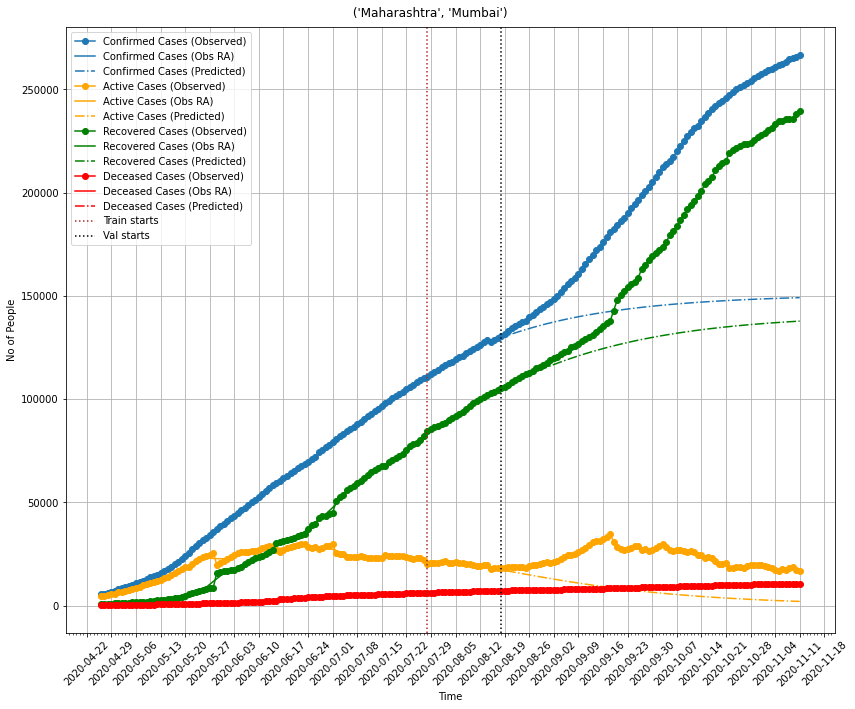

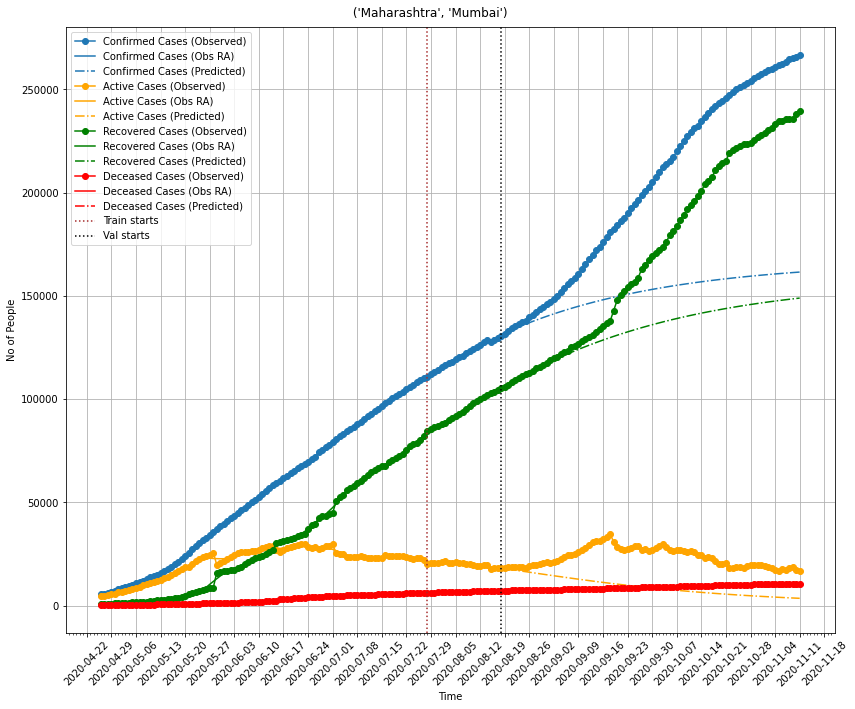

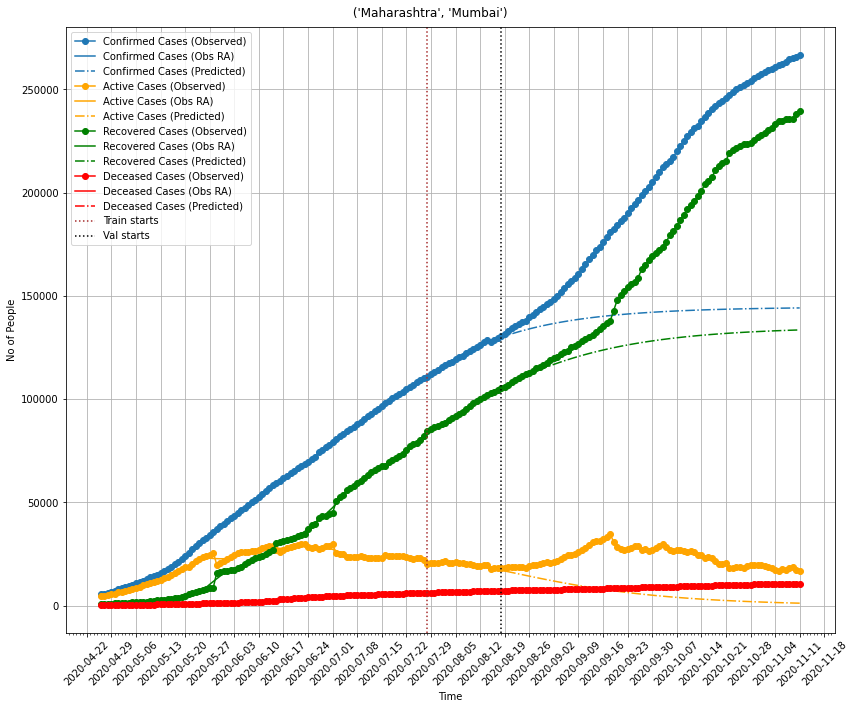

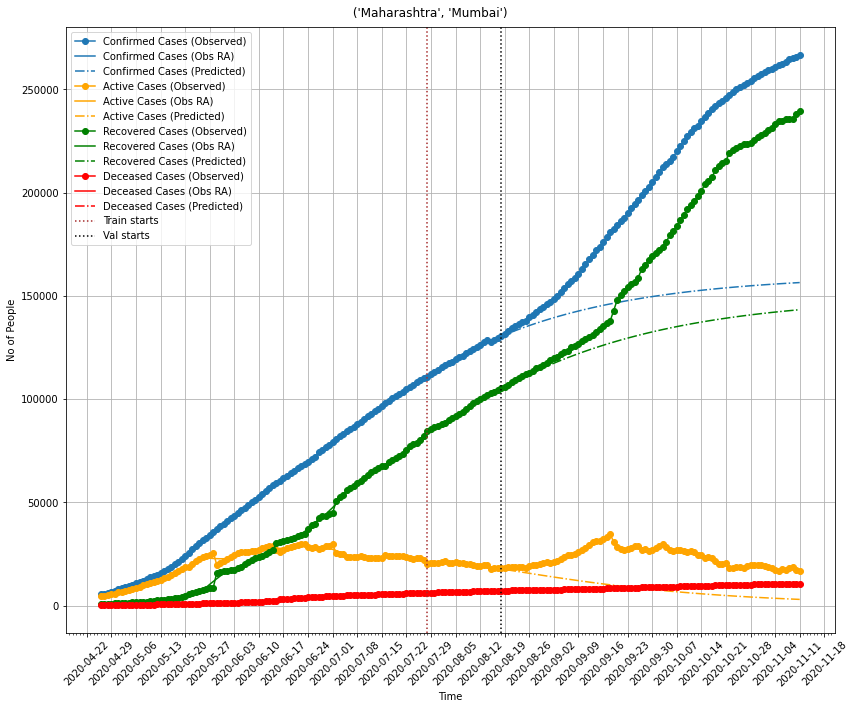

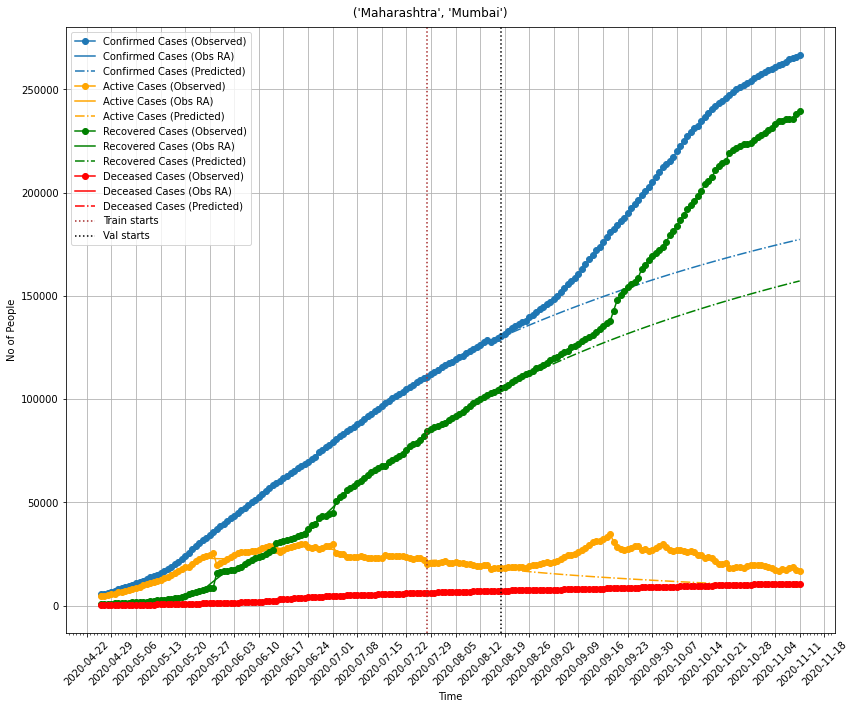

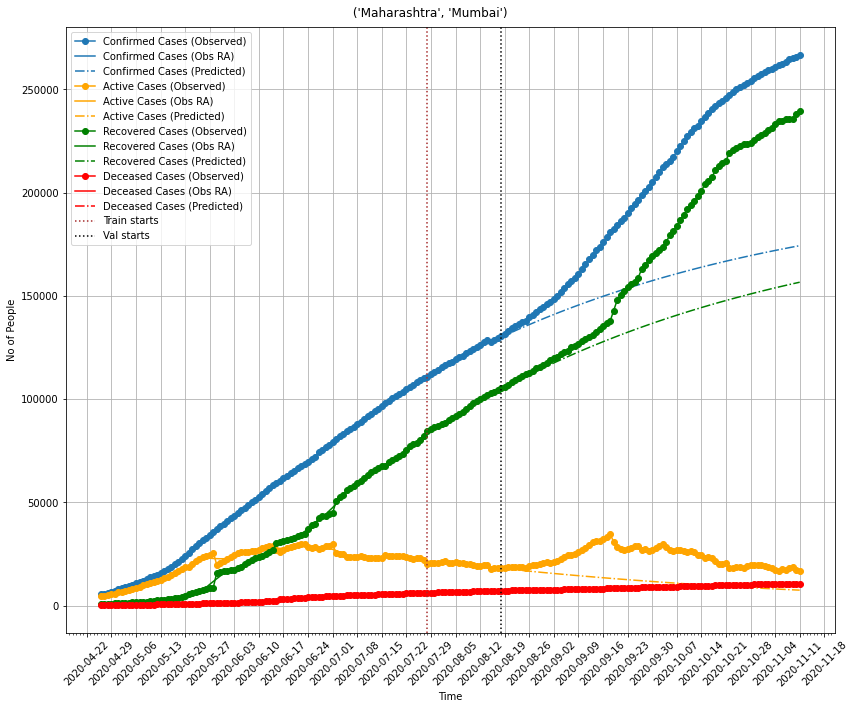

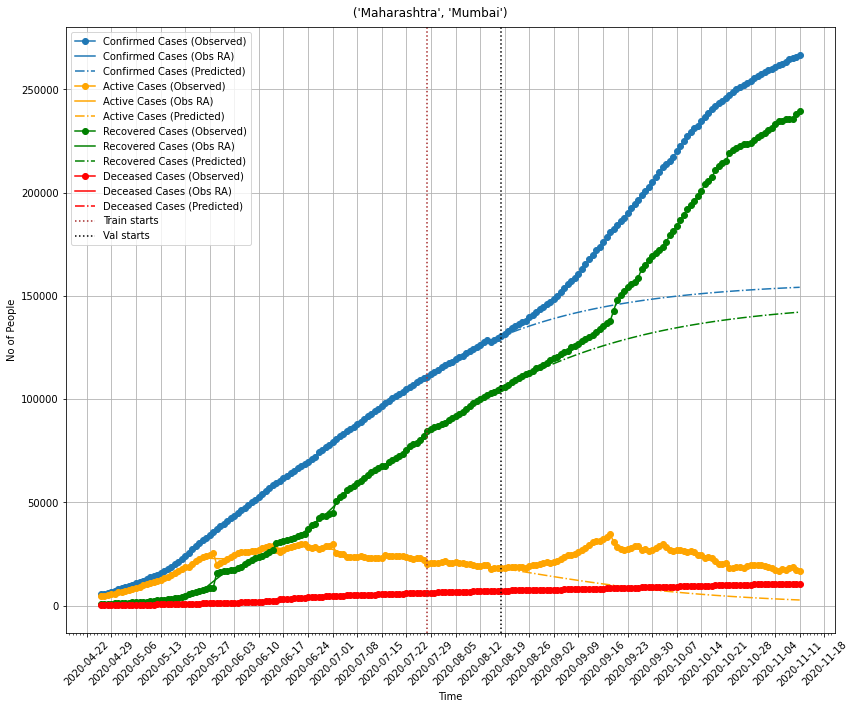

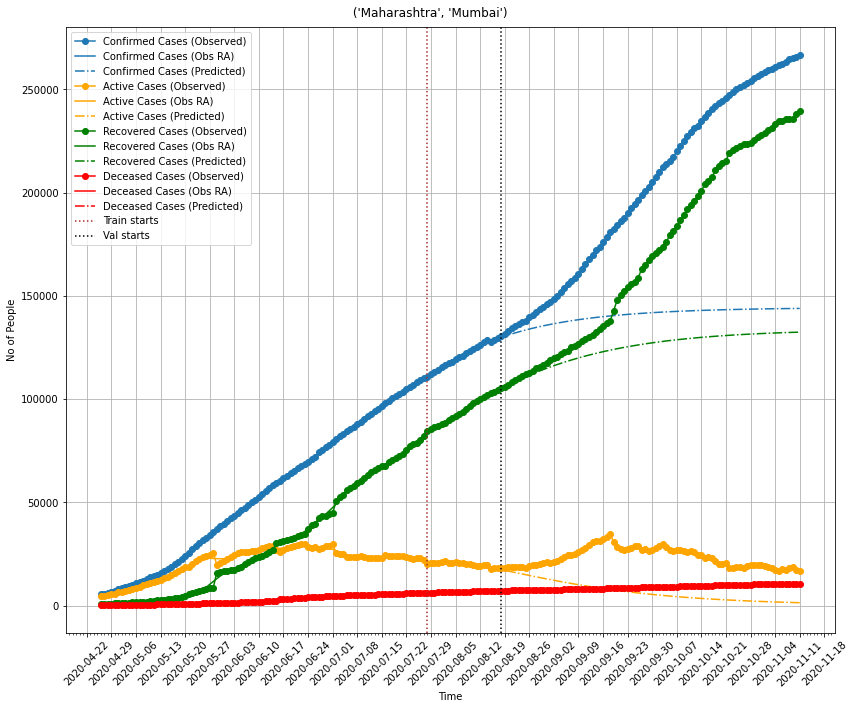

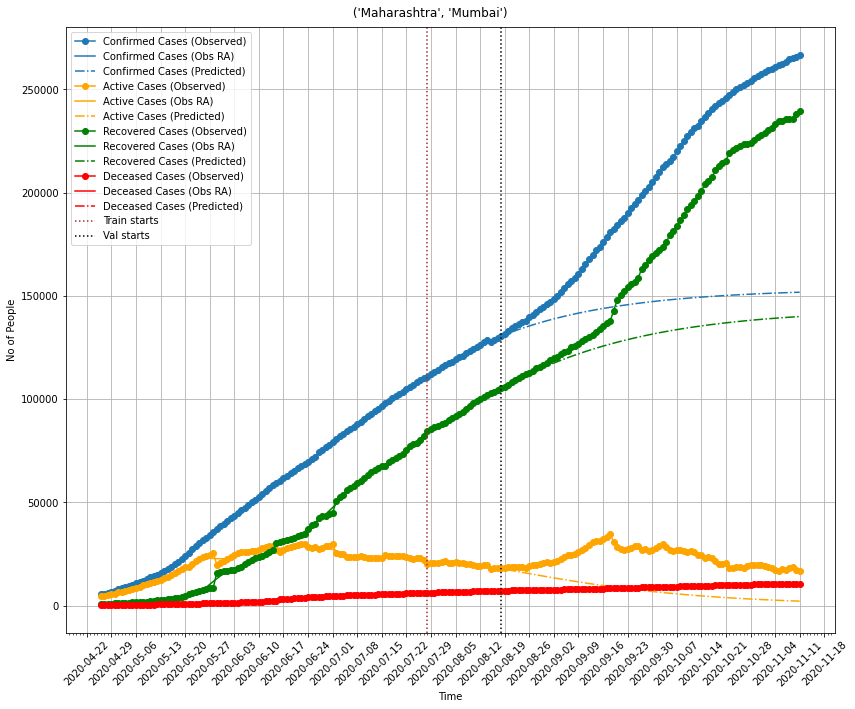

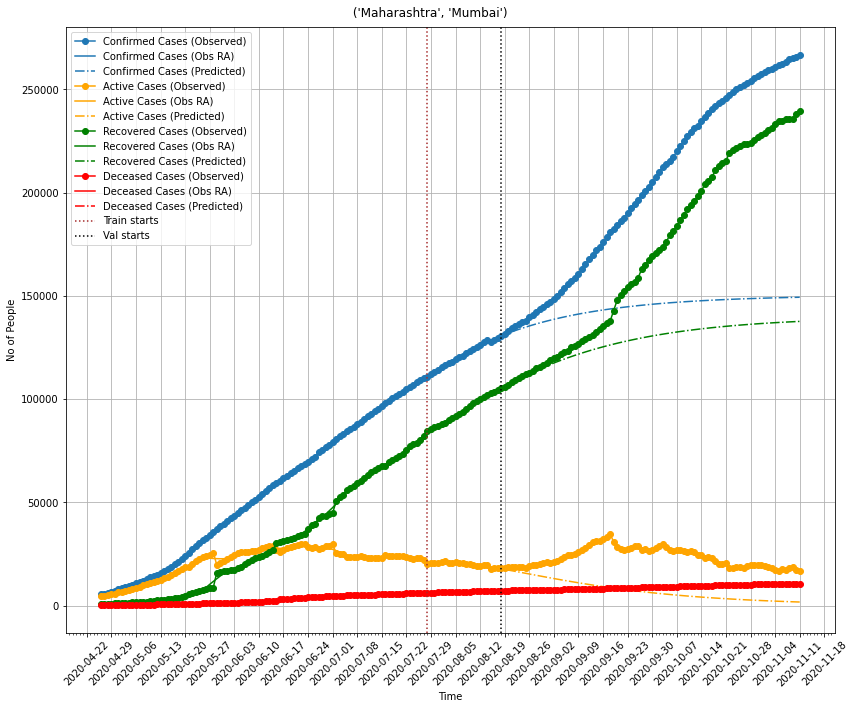

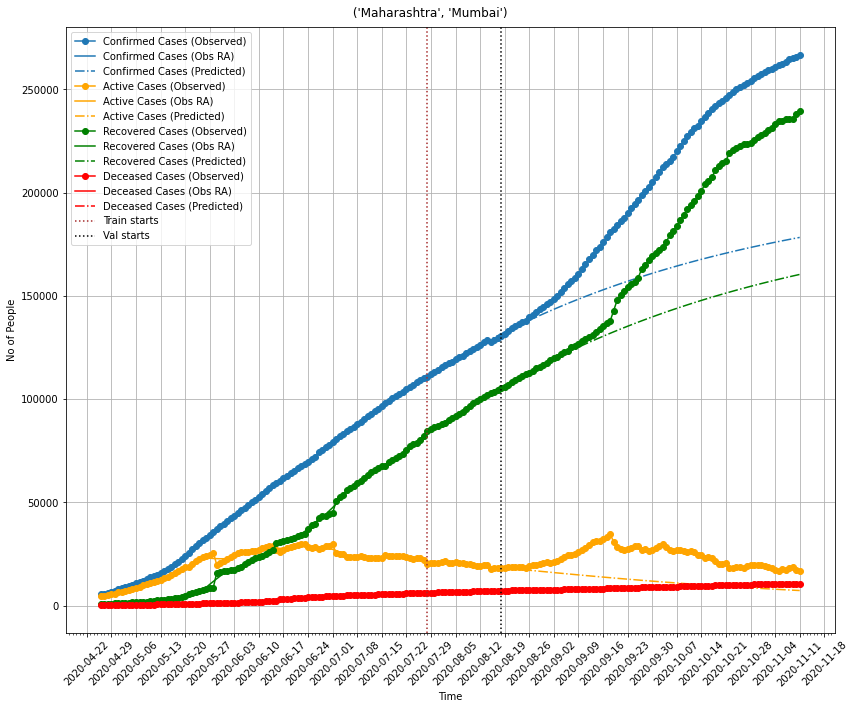

In [8]:
num_rep_trials = 10
for tag, end_date in enumerate(dates):
    predictions_dict[tag] = {}
    for j, config in enumerate(configs):
        predictions_dict[tag][model_names[j]] = {}
        config_params = copy.deepcopy(config['fitting'])
        config_params['split']['end_date'] = end_date.date()
        for k in range(num_rep_trials):
            predictions_dict[tag][model_names[j]][f'm{k}'] = single_fitting_cycle(**config_params)

In [9]:
with open('../../misc/predictions/predictions_dict_aug_10.pickle', 'wb') as handle:
    pkl.dump(predictions_dict, handle)

In [10]:
with open('../../misc/predictions/predictions_dict_aug_10.pickle', 'rb') as handle:
    predictions_dict = pkl.load(handle)

In [11]:
trials = []
for i in range(num_rep_trials):
    trials.append(f'm{i}')
trials

['m0', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9']

In [12]:
loss_type = ['train','val']
compartments = ['total', 'recovered', 'deceased']

In [13]:
import pandas as pd

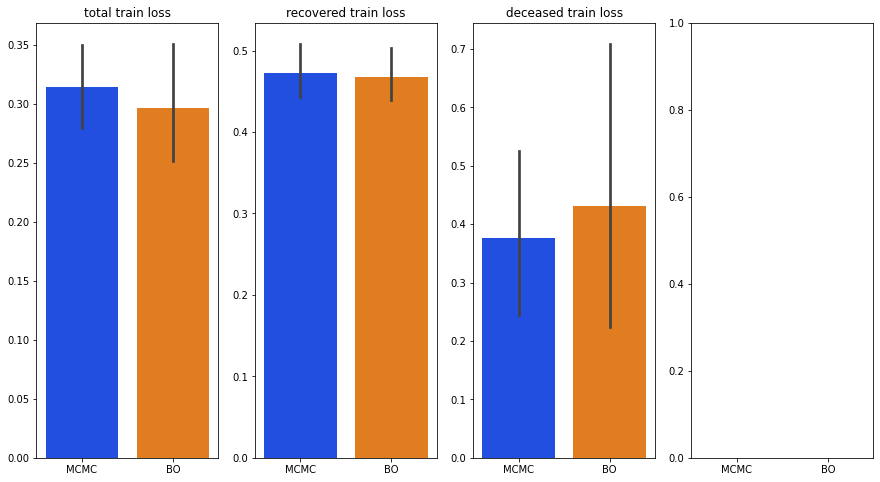

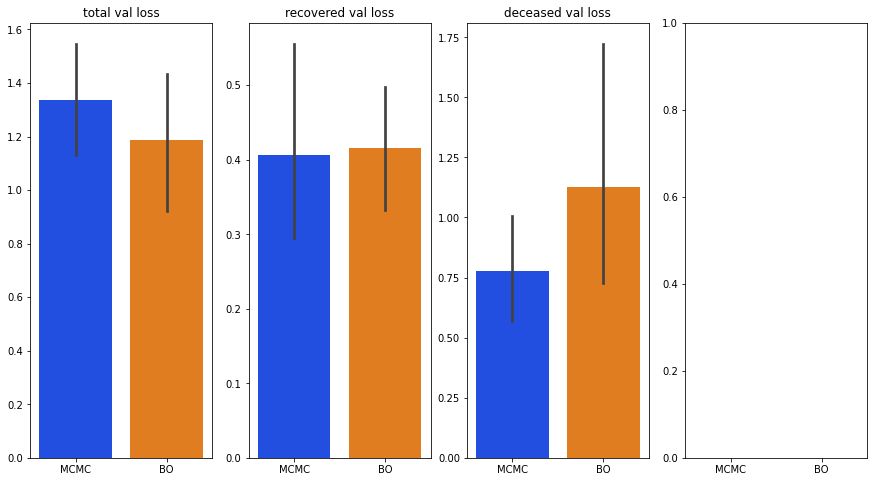

In [14]:
for l in loss_type:
    fig, AX = plt.subplots(nrows=1, ncols=4, sharex=True,figsize=(15, 8))
    for i,c in enumerate(compartments):
        MC_loss =[ predictions_dict[0]['MCMC'][i]['df_loss'][l][c] for i in trials]
        BO_loss =[ predictions_dict[0]['BO'][i]['df_loss'][l][c] for i in trials]
        data = {"MCMC":MC_loss,"BO":BO_loss}
        df = pd.DataFrame(data,columns = ["MCMC","BO"])
        sns.barplot(data =df ,ax = AX[i],palette = 'bright')
        AX[i].title.set_text(c+" "+l +" loss")

In [15]:
model_params = {
        'MCMC': [ 'lockdown_R0', 'T_inc', 'T_inf', 'T_inf', 'T_recov', 'T_recov_fatal', 'P_fatal', 'E_hosp_ratio', 'I_hosp_ratio','sigma'],
        'BO': [ 'lockdown_R0', 'T_inc', 'T_inf', 'T_inf', 'T_recov', 'T_recov_fatal', 'P_fatal', 'E_hosp_ratio', 'I_hosp_ratio','sigma'],
}

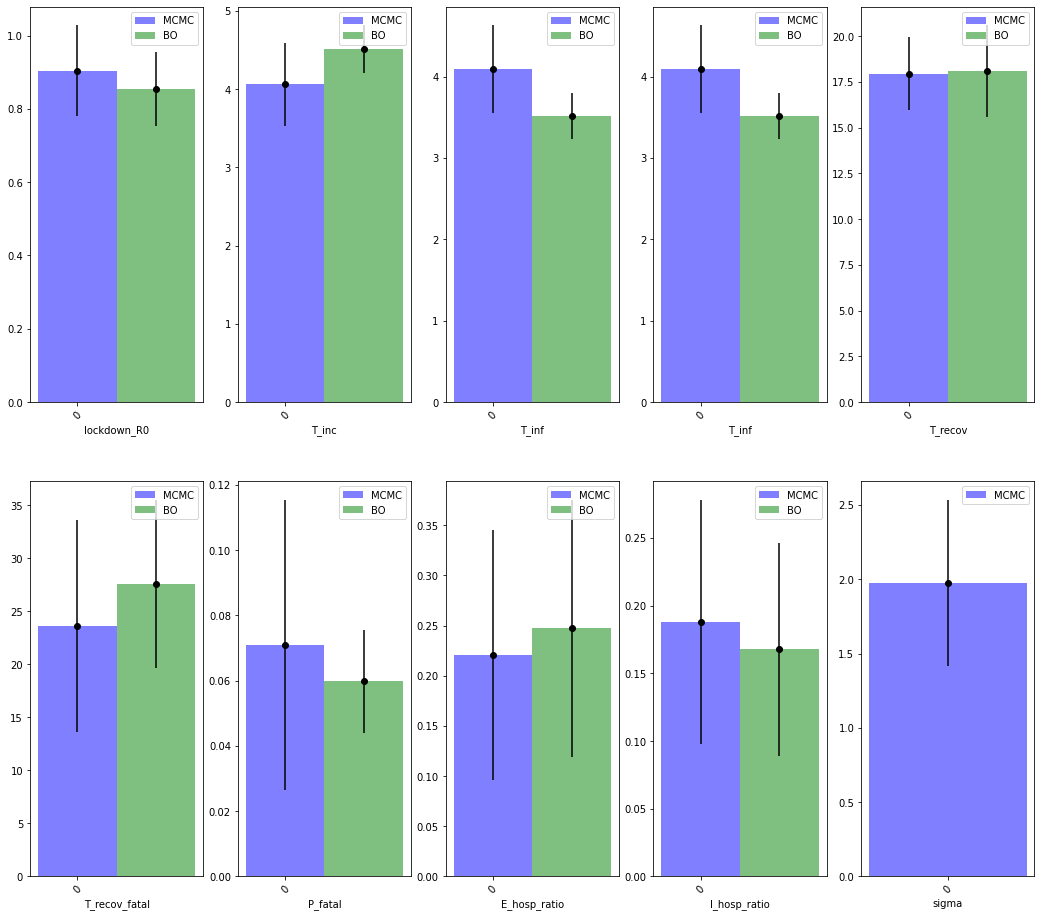

In [33]:
plot_all_params(predictions_dict, model_params, method='ensemble_combined')

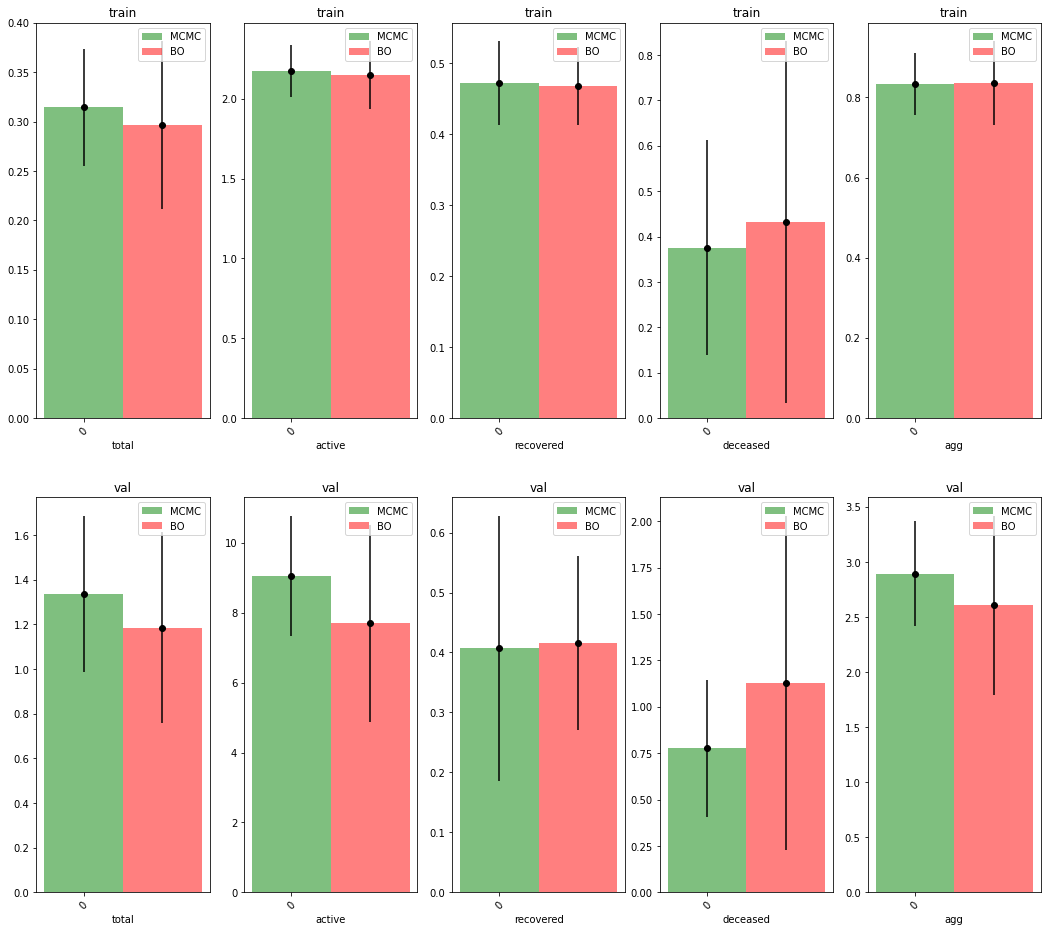

In [17]:
which_compartments = {model_names[i]: config['fitting']['loss']['loss_compartments'] for i, config in enumerate(configs)}
plot_all_losses(predictions_dict, which_losses=['train', 'val'], which_compartments=which_compartments)

In [18]:
from main.seir.forecast import _get_top_k_trials as topk

In [19]:
params,losses = topk(predictions_dict[tag][model_names[j]][f'm{k}'])

In [30]:
loss = {}
for tag in range (1):
    for j,mn in enumerate(model_names) :
        a = []
        for t in trials:
            _,l = topk(predictions_dict[tag][model_names[j]][t], k = 5)
            a.extend(l)
        if mn == 'MCMC':
            a = [4*i for i in a]
        loss[mn] = copy.copy(a)

In [31]:
(loss['MCMC'])

[0.4016033884440065,
 0.4724148789120255,
 0.5371977410783965,
 0.5803710611756834,
 0.5808452736865221,
 0.6256681986807993,
 0.6283640196464153,
 0.6283640196464153,
 0.6692227026076703,
 0.6692227026076703,
 0.5418531896535449,
 0.5473179350752477,
 0.5812288921747631,
 0.6159961341109819,
 0.6657258476007681,
 0.42085965527823466,
 0.5310654138350159,
 0.5522331914046714,
 0.6518347283951895,
 0.6610003787707767,
 0.5724069833459882,
 0.5977472919086319,
 0.5977472919086319,
 0.6140471675850082,
 0.6271493886596787,
 0.5857756911387947,
 0.6793378697269913,
 0.6809685487409582,
 0.6809685487409582,
 0.6809685487409582,
 0.4847835760979645,
 0.6079701337584773,
 0.649786959271762,
 0.6743183272572999,
 0.6819388596751101,
 0.5402723784404134,
 0.5415851586090055,
 0.5415851586090055,
 0.5600364825976812,
 0.6618691481040525,
 0.3559841966949094,
 0.583555395874688,
 0.6498609335326508,
 0.6900933960950688,
 0.7133919033637841,
 0.6232419898096679,
 0.6267906961947598,
 0.62679069619

Text(0.5, 1.0, 'Top 50 losses')

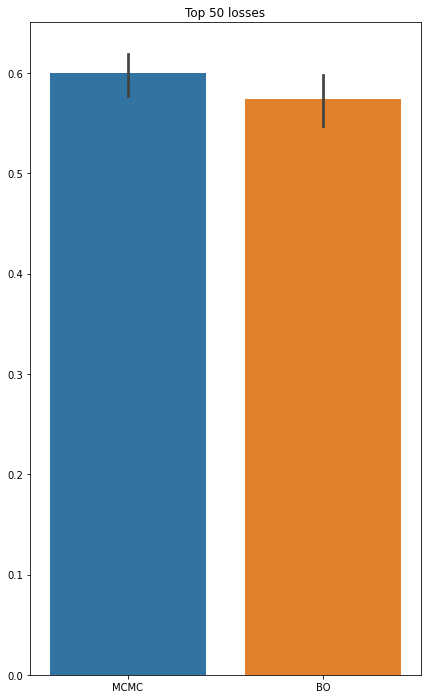

In [32]:
df = pd.DataFrame(loss,columns = ["MCMC","BO"])
plt.figure(
    figsize=(7,12))
sns.barplot(data = df )
plt.title("Top 50 losses")
